# Import em2d

In [90]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em2d as zpic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
import os
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Simulation Parameters

In [91]:
nx = [250, 250]
box = [10.0, 10.0]
dx = [box[0]/nx[0], box[1]/nx[1]]
dx_val = dx[0]
ppc = [6, 6]

dt_courant = 1 / np.sqrt(1.0/dx[0]**2 + 1.0/dx[1]**2)
dt = 0.99 * dt_courant

vth = 0
uth = [vth, vth, vth] # Initial thermal velocity
ufl = [0.0, 0.0, 0.0] # Initial fluid velocity

# Dispersion relation
omega_p = 1.0
def omega(x):
    return np.sqrt(1.0 + (1.5*x**2*uth[0]**2)/omega_p**2)

# Wave vector components
kx = 2

############################################################

# Envelope parameters
k_0x = 2 * np.pi
sigma_kx = 1

Delta_x = box[0]
Delta_kx = 2 * np.pi / Delta_x

print("Delta_kx = ", Delta_kx)

kx_min = k_0x - 4 * sigma_kx
kx_max = k_0x + 4 * sigma_kx
nx_waves = int((kx_max - kx_min) / Delta_kx)
kx_values = np.linspace(kx_min, kx_max, nx_waves)
kx_values = kx_values[kx_values > 0]

# 2D Gaussian in k-space
#def G_2D(kx_val, ky_val, k0x, k0y):
#    A = 1 / (2 * np.pi * sigma_kx * sigma_ky)
#    return A * np.exp(-(((kx_val - k0x)**2) / (2 * sigma_kx**2) +
#                        ((ky_val - k0y)**2) / (2 * sigma_ky**2)))

def G_1D(kx_val, k0x):
    A = 1 / (np.sqrt(2*np.pi*sigma_kx**2))
    alpha = 1 / (2*sigma_kx**2)
    return A * np.exp(-alpha*(kx_val-k0x)**2)

Delta_kx =  0.6283185307179586


# Define the density profile and the Electric field

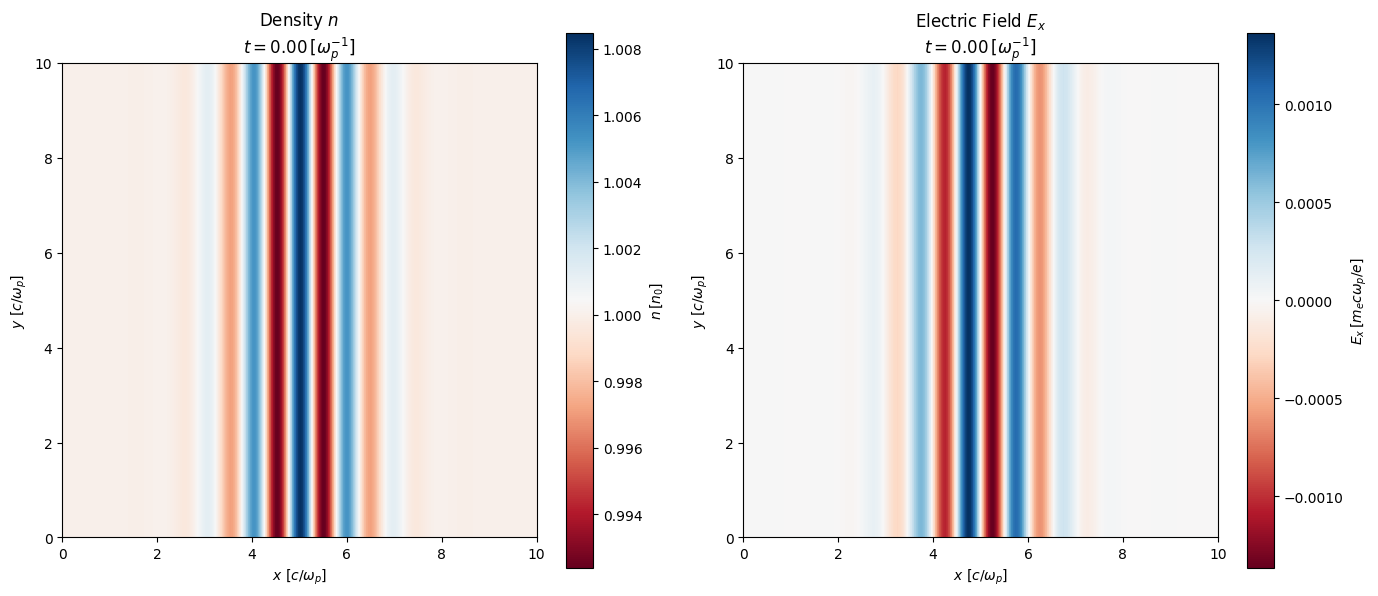

In [92]:
# Density profile
n0 = 1
def custom_n(x):
    n1_wave_sum = 0
    for kx_val in kx_values:
        amp = G_1D(kx_val, k_0x)
        phase = kx_val * (x - box[0]/2)
        n1_wave_sum += amp * np.cos(phase)

    # Multiply by the k-space increments
    n1_wave_sum *= Delta_kx / 100
    return n0 + n1_wave_sum

def custom_y(y):
    return 1

density = zpic.Density( type = "custom", custom_x = custom_n, custom_y = custom_y)

# Background plasma
electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl)
sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )
electrons.n_sort = 0

#Electric field
def E1_field( ix, iy, dx, dy ):
    # Ex is located at the center of the cell in x and at the bottom of the cell in y
    x = (ix+0.5)*dx_val
    E1_wave_sum_x = 0
    for kx_val in kx_values:
        amp = G_1D(kx_val, k_0x)
        phase = kx_val * (x - box[0]/2)
        
        E1_wave_sum_x += -amp / kx_val * np.sin(phase)

    E1_wave_sum_x  *= Delta_kx / 100

    return [E1_wave_sum_x,0,0]

E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )
sim.emf.init_fld( E_ext )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Density plot
im1 = ax1.imshow(np.abs(electrons.charge()), extent=[0, box[0], 0, box[1]], origin='lower', cmap='RdBu')
ax1.set_title(f"Density $n$\n$t  = {sim.t:.2f} \\,[\omega_p^{{-1}}]$")
ax1.set_xlabel(r"$x\ [c/\omega_p]$")
ax1.set_ylabel(r"$y\ [c/\omega_p]$")
fig.colorbar(im1, ax=ax1, label="$n \\,[n_0]$")

# Electric field plot (Ex)
im2 = ax2.imshow(sim.emf.Ex, extent=[0, box[0], 0, box[1]], origin='lower', cmap='RdBu')
ax2.set_title(f"Electric Field $E_x$\n$t  = {sim.t:.2f} \\,[\omega_p^{{-1}}]$")
ax2.set_xlabel(r"$x\ [c/\omega_p]$")
ax2.set_ylabel(r"$y\ [c/\omega_p]$")
fig.colorbar(im2, ax=ax2, label="$E_x \\,[m_ec\omega_p/e]$")

plt.tight_layout()
plt.show()



# Update the velocities after the simulation is created and before advancing the time step

In [93]:
print()
print(electrons.particles)

def v1_x(x):
    v1_wave_sum_x = 0
    for kx_val in kx_values:
        amp = G_1D(kx_val, k_0x)
        phase = kx_val * (x - box[0]/2)
        v1_wave_sum_x += amp * (omega(kx_val)/kx_val) * np.cos(phase)
    
    # Multiply by the k-space increments
    v1_wave_sum_x  *= Delta_kx / 100

    return v1_wave_sum_x


for particle in electrons.particles:
    pos_x = (particle['ix'] + particle['x']) * dx[0]
    particle['ux'] += v1_x(pos_x)

print()
print(electrons.particles)



[(  0,   0, 0.08333428, 0.08333334, 0., 0., 0.)
 (  0,   0, 0.08333428, 0.25      , 0., 0., 0.)
 (  0,   0, 0.08333428, 0.41666666, 0., 0., 0.) ...
 (249, 249, 0.91670865, 0.5833333 , 0., 0., 0.)
 (249, 249, 0.91670865, 0.75      , 0., 0., 0.)
 (249, 249, 0.91670865, 0.9166667 , 0., 0., 0.)]

[(  0,   0, 0.08333428, 0.08333334, -1.3654929e-06, 0., 0.)
 (  0,   0, 0.08333428, 0.25      , -1.3654929e-06, 0., 0.)
 (  0,   0, 0.08333428, 0.41666666, -1.3654929e-06, 0., 0.) ...
 (249, 249, 0.91670865, 0.5833333 , -1.3654933e-06, 0., 0.)
 (249, 249, 0.91670865, 0.75      , -1.3654933e-06, 0., 0.)
 (249, 249, 0.91670865, 0.9166667 , -1.3654933e-06, 0., 0.)]


# Run the simulation and check how n and E evolve


Running simulation up to t = 49.9825 ...
n = 1784, t = 49.9545
Done.


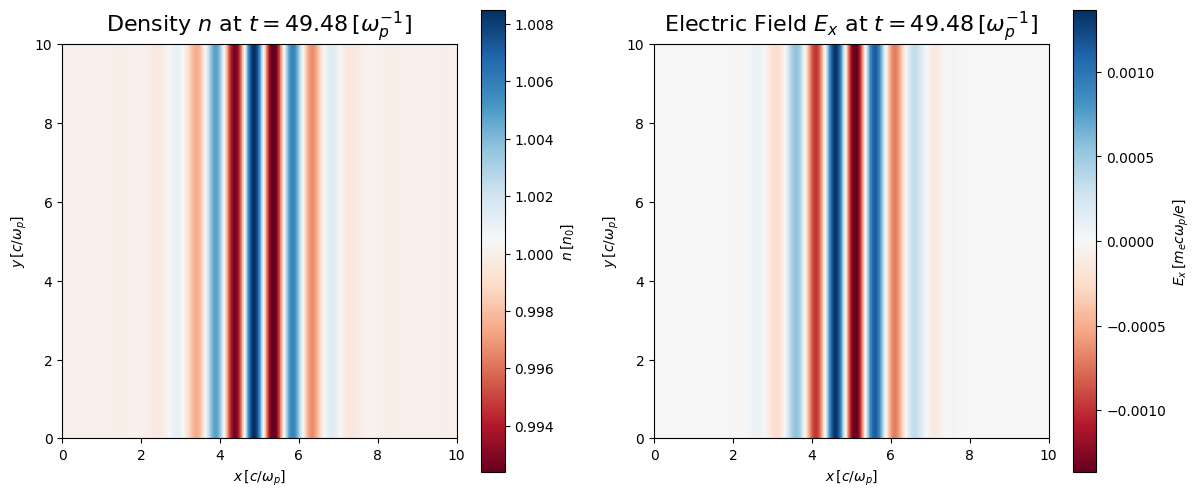

In [94]:
# Plot the first time frame
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Create imshows with a fixed extent and colormap.
im1 = ax1.imshow(np.abs(electrons.charge()), extent=[0, box[0], 0, box[1]], origin='lower', cmap='RdBu')
ax1.set_title(f"Density $n$\n$t = {0.0:.2f} \\,[\\omega_p^{-1}]$")
ax1.set_xlabel(r"$x\,[c/\omega_p]$")
ax1.set_ylabel(r"$y\,[c/\omega_p]$")
cb1 = fig.colorbar(im1, ax=ax1, label="$n \\,[n_0]$")

im2 = ax2.imshow(sim.emf.Ex, extent=[0, box[0], 0, box[1]], origin='lower', cmap='RdBu')
ax2.set_title(f"Electric Field $E_x$\n$t = {0.0:.2f} \\,[\\omega_p^{-1}]$")
ax2.set_xlabel(r"$x\,[c/\omega_p]$")
ax2.set_ylabel(r"$y\,[c/\omega_p]$")
cb2 = fig.colorbar(im2, ax=ax2, label="$E_x \\,[m_ec\omega_p/e]$")

# Save the initial color limits so they remain fixed
vmin1, vmax1 = im1.get_clim()
vmin2, vmax2 = im2.get_clim()

# Run the simulation

tmax = 50

''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
storing the values of n and E at every timestep so we can analyze them later. '''
niter = int(tmax / sim.dt)
Ex_t = np.zeros((niter, nx[0], nx[1]))
n_t = np.zeros((niter, nx[0], nx[1]))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
while sim.n < niter:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[sim.n,:] = sim.emf.Ex
    n_t[sim.n,:] =  np.abs(electrons.charge())
    sim.iter()

print("\nDone.")

# Movie parameters
nframes = 100
fps = 16

# Increase the embed limit if the movie is large
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 128


def animate(i):
    time_index = int(i * len(Ex_t) / nframes)

    # Reshape the 1D simulation data to 2D arrays (ny x nx) if necessary.
    density_frame = n_t[time_index, :]
    Ex_frame = Ex_t[time_index, :]
    
    # Update the image data for each imshow.
    im1.set_data(density_frame)
    im2.set_data(Ex_frame)
    
    # Reset the color limits to keep the first frame scale.
    im1.set_clim(vmin1, vmax1)
    im2.set_clim(vmin2, vmax2)
    
    # Optionally update the titles with the current simulation time.
    current_time = time_index * sim.dt
    ax1.set_title(f"Density $n$ at $t = {current_time:.2f}\\,[\\omega_p^{{-1}}]$", fontsize=16)
    ax2.set_title(f"Electric Field $E_x$ at $t = {current_time:.2f}\\,[\\omega_p^{{-1}}]$", fontsize=16)
    
    return (im1, im2)

# Define output folder and path.
output_folder = "2D_simulation_videos"
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, f"2Dwavepacket_vth={vth}.mp4")

# Create and save the movie using FFMpegWriter.
writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
with writer.saving(fig, output_path, dpi=100):
    for i in range(nframes):
        animate(i)  # update the imshow data
        writer.grab_frame()
